In [1]:
%load_ext autoreload
%autoreload 2

from ml4a import image
from ml4a.models import spade

#img = spade.run(img0)

imp  1 spade
imp 2 spade


imp  1 spade
imp 2 spade
[['1CXk6QPKeGLgp_VZwSUJFqnsvDuixx2fr', 'SPADE/checkpoints/Labels2Landscapes_512/iter.txt'], ['1tsfDW8xb_Vat3En3hqVmoAQQBp8umNdV', 'SPADE/checkpoints/Labels2Landscapes_512/latest_net_D.pth'], ['1T9FGxZQL9riB-a-cBOkFDdjBC2rf1Buh', 'SPADE/checkpoints/Labels2Landscapes_512/latest_net_G.pth'], ['17dLGaO0l2oiAp7QVopON-yXw8DDs-M0e', 'SPADE/checkpoints/Labels2Landscapes_512/loss_log.txt'], ['1b9n6RQN6GaSY8cvyZewM0xbNbAzJzGEF', 'SPADE/checkpoints/Labels2Landscapes_512/opt.pkl'], ['1kgqOc4mlvOt1gjxrCchnSyzp_6NgJ6wX', 'SPADE/checkpoints/Labels2Landscapes_512/opt.txt']]
Network [SPADEGenerator] was created. Total number of parameters: 97.4 million. To see the architecture, do print(network).
RUN!@@@2222
udhsdg
lbales 182


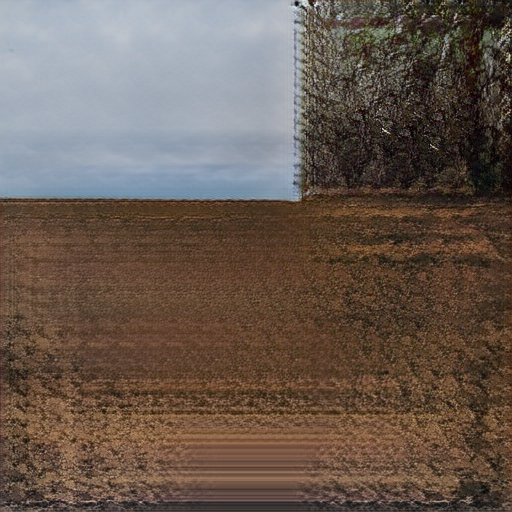

In [7]:
import numpy as np
img0 = np.zeros((1024, 512))

img0[:] = 105
img0[:, 300:] = 168
img0[400:, :] = 110

# labels: https://github.com/kazuto1011/deeplab-pytorch/blob/master/data/datasets/cocostuff/labels.txt

#img0[:,:,0] = 255
#image.display(img0)
img = spade.run(img0)
image.display(img)